In [53]:
import os
from PIL import Image

In [56]:
keeps = [ 'sword', 'pickaxe', 'axe']#, 'hoe', 'shovel' ]
mats = ['stone', 'diamond']#, 'iron', 'gold', 'wood', 'netherite']
# keeps = ['sword', 'pickaxe']
data = 'minecraft'
SIZE = 32

# reset the data directory
for file in os.listdir(data):
    os.remove(f"{data}/{file}")

for root, dirs, files in os.walk("textures"):
    # pack = root.split(os.sep)[-1]
    pack = root.split('textures/')[-1].replace('/', '-')

    # skip folders that end with '.disabled'
    if ".disabled" in pack:
        continue

    for file in files:
        if file.endswith(".png"):
            # skip normal maps
            if file.endswith("_n.png"):
                print(f"Skipping {root}/{file} because it is a normal map")
                continue

            if file.endswith("_s.png"):
                print(f"Skipping {root}/{file} because it is a specular map")
                continue
            
            if file.endswith("_e.png"):
                print(f"Skipping {root}/{file} because it is an emissive map")
                continue

            # TODO other possible types of maps

            # skip empty images
            if 'empty' in file:
                print(f"Skipping {root}/{file} because it is empty")
                continue

            for keep in keeps:
                if f"_{keep}" in file:
                    # skip if not a stone item
                    if 'stone' not in file and 'diamond' not in file:
                        print(f"Skipping {root}/{file} because it is not a stone item")
                        continue

                    # skip the file if it is not 32x32
                    try:
                        img = Image.open(f"{root}/{file}")
                        if img.size[0] != img.size[1]:
                            print(f"Skipping {root}/{file} because it is not a square ({img.size})")
                            continue
                        if img.size[0] < SIZE:
                            print(f"skipping {root}/{file} because it is not 32x32 ({img.size})")
                            continue

                        os.system(f"cp {root}/{file} {data}/{pack}-{file}")
                    except Exception as e:
                        print(f"Skipping {root}/{file} because it is not an image: {e}")
                    

Skipping textures/helios/netherite_sword.png because it is not a stone item
Skipping textures/helios/wooden_axe.png because it is not a stone item
Skipping textures/helios/wooden_sword.png because it is not a stone item
Skipping textures/helios/golden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_axe.png because it is not a stone item
Skipping textures/helios/netherite_pickaxe.png because it is not a stone item
Skipping textures/helios/wooden_pickaxe.png because it is not a stone item
Skipping textures/helios/golden_sword.png because it is not a stone item
Skipping textures/helios/iron_pickaxe.png because it is not a stone item
Skipping textures/helios/netherite_axe.png because it is not a stone item
Skipping textures/helios/iron_sword.png because it is not a stone item
Skipping textures/helios/iron_axe.png because it is not a stone item
Skipping textures/helios/tools/silk/gold_pickaxe_04.png because it is not a stone item
Skipping textures/helios/tools/sil

In [57]:
# replace the alpha channel with a solid color using pil
for file in os.listdir(data):
    if file.endswith(".png"):
        img = Image.open(f"{data}/{file}")
        img = img.convert("RGBA")

        if img.size[0] > SIZE:
            print(f"resizing {root}/{file} because it is not {SIZE}x{SIZE} ({img.size})")
            img = img.resize((SIZE, SIZE), Image.NEAREST) # TODO Image.NearestNeighbour
            img.save(f"{root}/{file}")

        datas = img.getdata()
        new_data = []
        for item in datas:
            if item[3] == 0:
                # if the pixel is transparent, replace it with white
                new_data.append((255, 255, 255, 255))
            else:
                new_data.append(item)
        img.putdata(new_data)
        img.save(f"{data}/{file}", "PNG")
        # break

resizing textures/StevensTraditional/models/WolfhoundFantasy-stone_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-diamond_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/WolfhoundHeavenly-diamond_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_pickaxe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/DragonDance-stone_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-stone_sword_broken.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/Invictus-6-diamond_axe.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/WolfhoundAsian-diamond_sword.png because it is not 32x32 ((64, 64))
resizing textures/StevensTraditional/models/XmasBDcraft-diamond_axe.png because it is not 32x32 ((64, 64))
resizing te

In [95]:
from sentence_transformers import SentenceTransformer, util
import torch.nn as nn
sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
compressor = nn.Linear(384, 18).to('mps')

In [59]:
# convert the files into a dataset using the dataset lib
import numpy as np

labels = {
    'sword': 0,
    'pickaxe': 1,
    'axe': 2,
    'hoe': 3,
    'shovel': 4
}

def get_label(file):
    if 'sword' in file:
        return 0
    if 'pickaxe' in file:
        return 1
    if 'axe' in file:
        return 2
    if 'hoe' in file:
        return 3
    if 'shovel' in file:
        return 4
    
    # throw an error if the label is not found
    raise Exception(f"Label not found for {file}")

# load the images
dataset = []
for file in os.listdir(data):
    if file.endswith(".png"):
        # img = Image.open(f"{data}/{file}")
        # open the image in black and white
        img = Image.open(f"{data}/{file}")#.convert("L")
        # drop the alpha channel
        img = img.convert("RGB")
        # load image into numpy array and normalize
        img = np.array(img) / 255
        # TODO split on - and _ then flatten
        name = file.replace('_', ' ').replace('.png', '')#.replace('-', ' ')
        # drop the pack name
        name = name.split('-')[1]
        embedding = model.encode(name, convert_to_tensor=True)
        print(embedding)
        # maybe try for between 0 and 1
        # embedding = compressor(embedding).cpu()
        # y = (x + 1) / 2
        # embedding = (embedding + 1) / 2
        print(embedding)

        dataset.append((img, get_label(file), embedding.cpu()))

# create the dataset
# images_np = np.array(images)
# images_np = images_np.reshape((images_np.shape[0], 32, 32, 4))
# print(images_np.shape)

# dataset = (images_np, labels)

# store the dataset into a pickle file
import pickle
pickle.dump(dataset, open("mc-dataset.pkl", "wb"))

hidden_states[0][0][:8]=tensor([ 0.2615,  0.0308, -0.1059, -0.1503,  0.0892, -0.0578, -0.1278, -0.0283],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.1786, -0.1673, -0.0664, -0.0103,  0.0334, -0.0691, -0.1830, -0.0331],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.0408, -0.1849,  0.0748, -0.0346,  0.2017, -0.0135, -0.0822, -0.0600],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.3635, -0.5218, -0.1798, -0.1136,  0.0269,  0.1208,  0.0036,  0.3521],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-1.0594, -0.7629, -0.3201, -0.4678, -0.2864,  0.5239, -0.0633,  0.5112],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.9186, -0.6587, -0.6477, -1.3605, -0.2300,  0.7449,  0.0817,  0.0951],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.6852, -0.4216, -1.0462, -0.8217, -0.1442,  0.3329,  0.1192,  0.5787],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.6683, -0.4661, -0.9214, -0.9819,  0.0814, -0.0075,  0.6035,  0.1699],

KeyboardInterrupt: 

In [42]:
#%pip install fastai

In [43]:
import numpy as np
import fastai
import matplotlib.pyplot as plt

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [44]:
bs = 16
size = 32

In [45]:
%matplotlib inline

In [46]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop),
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
                  )

In [47]:
# load data from local path
path = 'minecraft'
dls = dblock.dataloaders(path, path=path, bs=bs)
len(dls.train.dataset)
print(type(dls))

<class 'fastai.data.core.DataLoaders'>


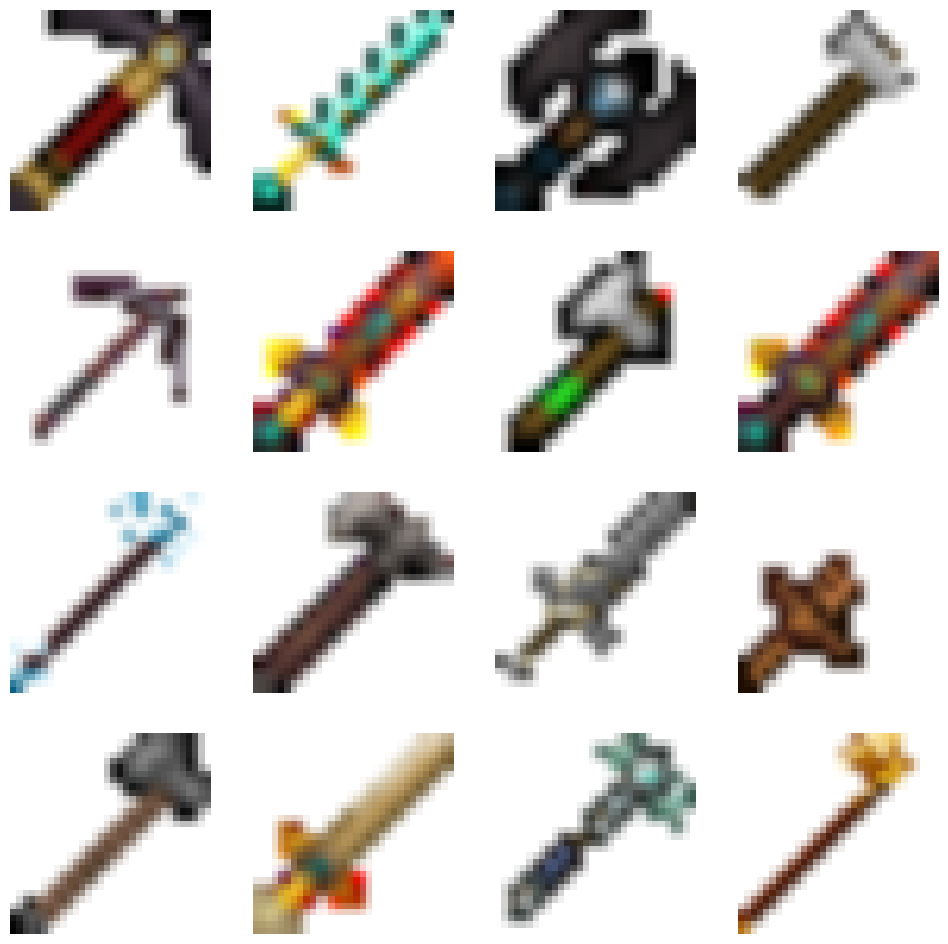

In [48]:
dls.show_batch(max_n=16)

In [32]:
generator = basic_generator(32, n_channels=3, n_extra_layers=1)

critic    = basic_critic(
                    32, 
                    n_channels=3, 
                    n_extra_layers=1, 
                    act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
)

In [33]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [34]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [35]:
# create a callback to print the gan stats every 10 iterations
class PrintLoss(Callback):
    def after_batch(self):
        if self.iter % 10 == 0:
            gen_loss = self.learn.recorder.losses[-2] if len(self.learn.recorder.losses) > 2 else 0
            crit_loss = self.learn.recorder.losses[-1] if len(self.learn.recorder.losses) > 1 else 0
            # print(f'iter {self.iter} | gen_loss {gen_loss:.4f} | crit_loss {crit_loss:.4f}')

In [36]:
with learn.no_logging():
    learn.fit(100, 2e-4, wd=0., cbs=[PrintLoss()])

KeyboardInterrupt: 

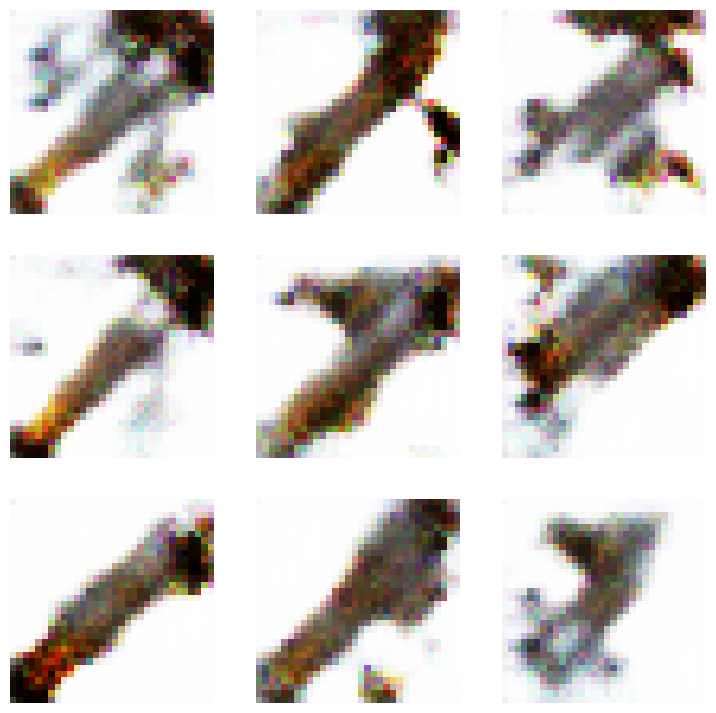

In [ ]:
## matplotlib inline
learn.show_results(max_n=9, ds_idx=0)
## %matplotlib inline
## plt.show()

In [ ]:
# create random y vector where each y is a random number between 0 and 10
classes = 10
batch = 8
y = torch.randint(0, classes, (1, batch))
y = F.one_hot(y, num_classes=classes).squeeze(0)
print(y)

# create a batch of random noise
noise = torch.randn(batch, 100)
# create a batch of random ohe class labels
y = torch.randint(0, classes, (1, batch))

# concatenate the noise and the class labels
z = torch.cat([noise, y.float()], dim=1)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 8 but got size 1 for tensor number 1 in the list.

In [64]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
# model = BertForSequenceClassification.from_pretrained("google/bert_uncased_L-12_H-128_A-2", classes=10)
# create a sentence similarity model
print(classes)
model = BertForSequenceClassification.from_pretrained("google/bert_uncased_L-2_H-128_A-2", num_labels=18)
print(model.config.num_labels)
print(model.config)
print(tokenizer.vocab_size)

# do a forward pass
# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = model(**inputs, labels=labels)
# loss = outputs.loss
# logits = outputs.logits
# print(loss)

# do a simple sentence similarity
inputs = tokenizer("wooden sword", return_tensors="pt")
outputs = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state

inputs = tokenizer("baby cat", return_tensors="pt")
outputs1 = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state
print ('#################')
print(outputs1)
print(outputs[0].detach().numpy())

# find the similarity between the two sentences
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(outputs[0].detach().numpy(), outputs1[0].detach().numpy()))


NameError: name 'classes' is not defined

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# Load model
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", classes=18)

# do a simple sentence similarity
inputs = tokenizer("wooden sword", return_tensors="pt")
outputs = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state

inputs = tokenizer("stone sword", return_tensors="pt")
outputs2 = model(**inputs) # ugh my test code is in there

inputs = tokenizer("baby cat", return_tensors="pt")
outputs1 = model(**inputs) # ugh my test code is in there
# last_hidden_states = outputs.last_hidden_state
print ('#################')
print(outputs1)
print(outputs)
print(outputs2)



TypeError: __init__() got an unexpected keyword argument 'classes'

$ ||\overrightarrow{a}||_2 - ||\overrightarrow{b}||_2 $

In [91]:
#%pip install -U sentence-transformers
import torch.nn as nn
import torch
from sentence_transformers import SentenceTransformer, util
sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone", "stone pickaxe"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)
embedding_5 = model.encode(sentences[4], convert_to_tensor=True)
print(embedding_1[:5])

# change the size of the embeddings to 1x18
compressor = nn.Linear(384, 18, bias=False).to('mps')
# compressor.weight = nn.Parameter(torch.ones(18, 384, device='mps'))

embedding_1 = compressor(embedding_1)
embedding_2 = compressor(embedding_2)
embedding_3 = compressor(embedding_3)
embedding_4 = compressor(embedding_4)
embedding_5 = compressor(embedding_5)

print('#################')
print(embedding_1)
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
print(f'{sentences[0]} ?= {sentences[4]} =', util.pytorch_cos_sim(embedding_1, embedding_5))
## tensor([[0.6003]])

# increase desparity between the two embeddings
# embedding_1 = embedding_1 * 50
print(embedding_2)
embedding_2 = embedding_2 * 50
print(embedding_2)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))

hidden_states[0][0][:8]=tensor([-0.0018, -0.0170, -0.0163,  0.0287, -0.0069, -0.0030, -0.0530, -0.0304],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0453,  0.0115, -0.0139, -0.0002, -0.0139, -0.0106, -0.0454, -0.0009],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0177, -0.0120, -0.0141,  0.0120, -0.0206, -0.0121, -0.0071, -0.0126],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0093,  0.0134,  0.0021,  0.0103, -0.0459, -0.0136, -0.0667, -0.0077],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0336,  0.0265, -0.0121, -0.0097, -0.0570, -0.0029, -0.0546, -0.0594],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.1401,  0.2690,  0.2983,  0.0996, -0.3445,  0.2047, -0.0636, -0.4953],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0014, -0.0175, -0.0161,  0.0291, -0.0068, -0.0064, -0.0530, -0.0314],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.0446,  0.0126, -0.0123,  0.0016, -0.0138, -0.0108, -0.0465,  0.0004],

In [67]:
from sentence_transformers import SentenceTransformer, models, util
from torch import nn

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(
    in_features=pooling_model.get_sentence_embedding_dimension(),
    out_features=256,
    activation_function=nn.Tanh(),
)

sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone", "stone pickaxe"]

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)
embedding_5 = model.encode(sentences[4], convert_to_tensor=True)

print('#################')
print(embedding_1)
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
print(f'{sentences[0]} ?= {sentences[4]} =', util.pytorch_cos_sim(embedding_1, embedding_5))

hidden_states[0][0][:8]=tensor([ 0.2596, -0.0066, -0.1313, -0.1524,  0.0552, -0.0831, -0.1133, -0.0486],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.1486, -0.2130, -0.1888,  0.0201,  0.0859, -0.0835, -0.2000, -0.0715],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.0589, -0.2608, -0.0081,  0.0694,  0.2005, -0.0195, -0.1297, -0.0760],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.1239, -0.3011, -0.4410,  0.0369,  0.1039, -0.0055, -0.2264,  0.3227],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.4338, -0.4860, -0.5066, -0.0463, -0.0528,  0.2142, -0.2909,  0.4268],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.5189, -0.5348, -0.5520, -0.7558, -0.2293,  0.2390, -0.3380,  0.5862],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.5507, -0.4810, -0.6499, -0.2746, -0.0947,  0.4775, -0.2386,  0.5807],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.7008, -0.3903, -0.7424, -0.4312, -0.1952,  0.0271,  0.0105,  0.2700],

In [1]:
items = [ 'sword', 'pickaxe', 'axe', 'hoe', 'shovel' ]
mats = [ 'stone', 'diamond', 'iron', 'gold', 'wood', 'netherite' ]
combs = []

for item in items:
    for mat in mats:
        combs.append(f"{mat} {item}")
        combs.append(f"{item} {mat}")

dataset = []
for comb in combs:
    for comb2 in combs:
        text1 = comb.split(' ')
        text2 = comb2.split(' ')
        # if text1[0] == text2[0] and text1[1] == text2[1]:
        #     similarity = 1
        # elif text1[0] == text2[1] and text1[1] != text2[0]:
        #     similarity = 0.5
        # smart
        similarity = 0
        for word in text1:
            if word in text2:
                similarity += 0.5

        dataset.append({ 'texts': (comb, comb2), 'similarity': similarity })
    
display(dataset)
print(len(dataset))

[{'texts': ('stone sword', 'stone sword'), 'similarity': 1.0},
 {'texts': ('stone sword', 'sword stone'), 'similarity': 1.0},
 {'texts': ('stone sword', 'diamond sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword diamond'), 'similarity': 0.5},
 {'texts': ('stone sword', 'iron sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword iron'), 'similarity': 0.5},
 {'texts': ('stone sword', 'gold sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword gold'), 'similarity': 0.5},
 {'texts': ('stone sword', 'wood sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword wood'), 'similarity': 0.5},
 {'texts': ('stone sword', 'netherite sword'), 'similarity': 0.5},
 {'texts': ('stone sword', 'sword netherite'), 'similarity': 0.5},
 {'texts': ('stone sword', 'stone pickaxe'), 'similarity': 0.5},
 {'texts': ('stone sword', 'pickaxe stone'), 'similarity': 0.5},
 {'texts': ('stone sword', 'diamond pickaxe'), 'similarity': 0},
 {'texts': ('stone sword', 'pickaxe diamond

3600


In [4]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
import torch.nn as nn

# model = SentenceTransformer("distilbert-base-nli-mean-tokens")

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(
    in_features=pooling_model.get_sentence_embedding_dimension(),
    out_features=18,
    activation_function=nn.Tanh(),
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

train_examples = [
    InputExample(texts=d['texts'], label=d['similarity']) for d in dataset
]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [52]:
sentences = ["stone sword", "I'm full of happiness", "wooden sword", "sword stone", "stone pickaxe"]

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)
embedding_3 = model.encode(sentences[2], convert_to_tensor=True)
embedding_4 = model.encode(sentences[3], convert_to_tensor=True)
embedding_5 = model.encode(sentences[4], convert_to_tensor=True)

print('#################')
print(embedding_1)
print(embedding_1.shape)
print(embedding_2.shape)
print(f'{sentences[0]} ?= {sentences[1]} =', util.pytorch_cos_sim(embedding_1, embedding_2))
print(f'{sentences[0]} ?= {sentences[2]} =', util.pytorch_cos_sim(embedding_1, embedding_3))
print(f'{sentences[0]} ?= {sentences[3]} =', util.pytorch_cos_sim(embedding_1, embedding_4))
print(f'{sentences[0]} ?= {sentences[4]} =', util.pytorch_cos_sim(embedding_1, embedding_5))

hidden_states[0][0][:8]=tensor([ 0.2434,  0.0363, -0.0941, -0.1773,  0.0610, -0.0603, -0.1253, -0.0386],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.1617, -0.1800, -0.0661,  0.0133,  0.0521, -0.0514, -0.1717, -0.0684],
       device='mps:0')
hidden_states[0][0][:8]=tensor([ 0.0128, -0.1866,  0.0764,  0.0175,  0.2212,  0.0070, -0.0781, -0.0771],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.1855, -0.3101, -0.2081,  0.0758,  0.0767,  0.0554, -0.1600,  0.1475],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.5305, -0.3693, -0.2249,  0.0908, -0.1401,  0.3820, -0.2446,  0.2842],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.5846, -0.3072, -0.5865, -0.7318, -0.1194,  0.7073, -0.2046,  0.2286],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.2812, -0.1587, -0.7433, -0.5962, -0.0643,  1.0050,  0.0057,  0.2946],
       device='mps:0')
hidden_states[0][0][:8]=tensor([-0.6009, -0.0546, -0.7106, -0.5159, -0.1300,  0.3526,  0.2469, -0.0542],